%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [2]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot
from tools import NMD as nmd

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import kendalltau
import importlib

In [3]:
def plot_reconstruction(
    X_reconstruction, X, title,hue=None, type="scatter", sample_fraction=None
):
    """Plot original sparse non-negative matrix against the reconstructed one

    Also computes the Pearson correlation between both

    Args:
        X_reconstruction (_type_): Reconstructed matrix, e.g. np.maximum(0, Theta)
        X (_type_): The original sparse non-negative matrix
        title (_type_): _description_
        type (str, optional): _description_. Defaults to "scatter".
        sample_fraction (_type_, optional): _description_. Defaults to None.
    """
    X_recon_max = np.max(X_reconstruction)
    X_max = np.max(X)
    max_axis = max(X_recon_max, X_max)
    correlation = np.corrcoef(X_reconstruction.flatten(), X.flatten())[0][1]

    df = pd.DataFrame(
        {"original": X.flatten(), "reconstruction": X_reconstruction.flatten()}
    )

    if sample_fraction:
        df = df.sample(frac=sample_fraction, axis=0)

    fig, ax = plt.subplots()
    match type:
        case "scatter":
            if hue is not None:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", hue=hue, alpha=0.1)
            else:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", alpha=0.1)
        # case "kde":
        # p = sns.kdeplot(X_reconstruction.flatten(), X.flatten())
        # p = sns.kdeplot(data=df, x="reconstruction", y="original")
    p.set_ylim(0, max_axis)
    p.set_xlim(0, max_axis)
    plt.suptitle(title)
    plt.title(f"Pearson correlation: {round(correlation, 3)}")
    plt.xlabel("Reconstruction")
    plt.ylabel("Original data")
    ax.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
    plt.show()


In [4]:
data_all_pca = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/export_s2.h5ad")
data_all_pca

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
data_all_pca.varm["PCs"].shape

(5540, 50)

In [6]:
data_counts = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/S2_filtered_with_counts.h5ad")
data_counts

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'

In [7]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

In [8]:
data_all_pca.uns["leiden_opt_colors"]

array(['#1f77b4', '#d62728', '#e377c2', '#17becf'], dtype=object)

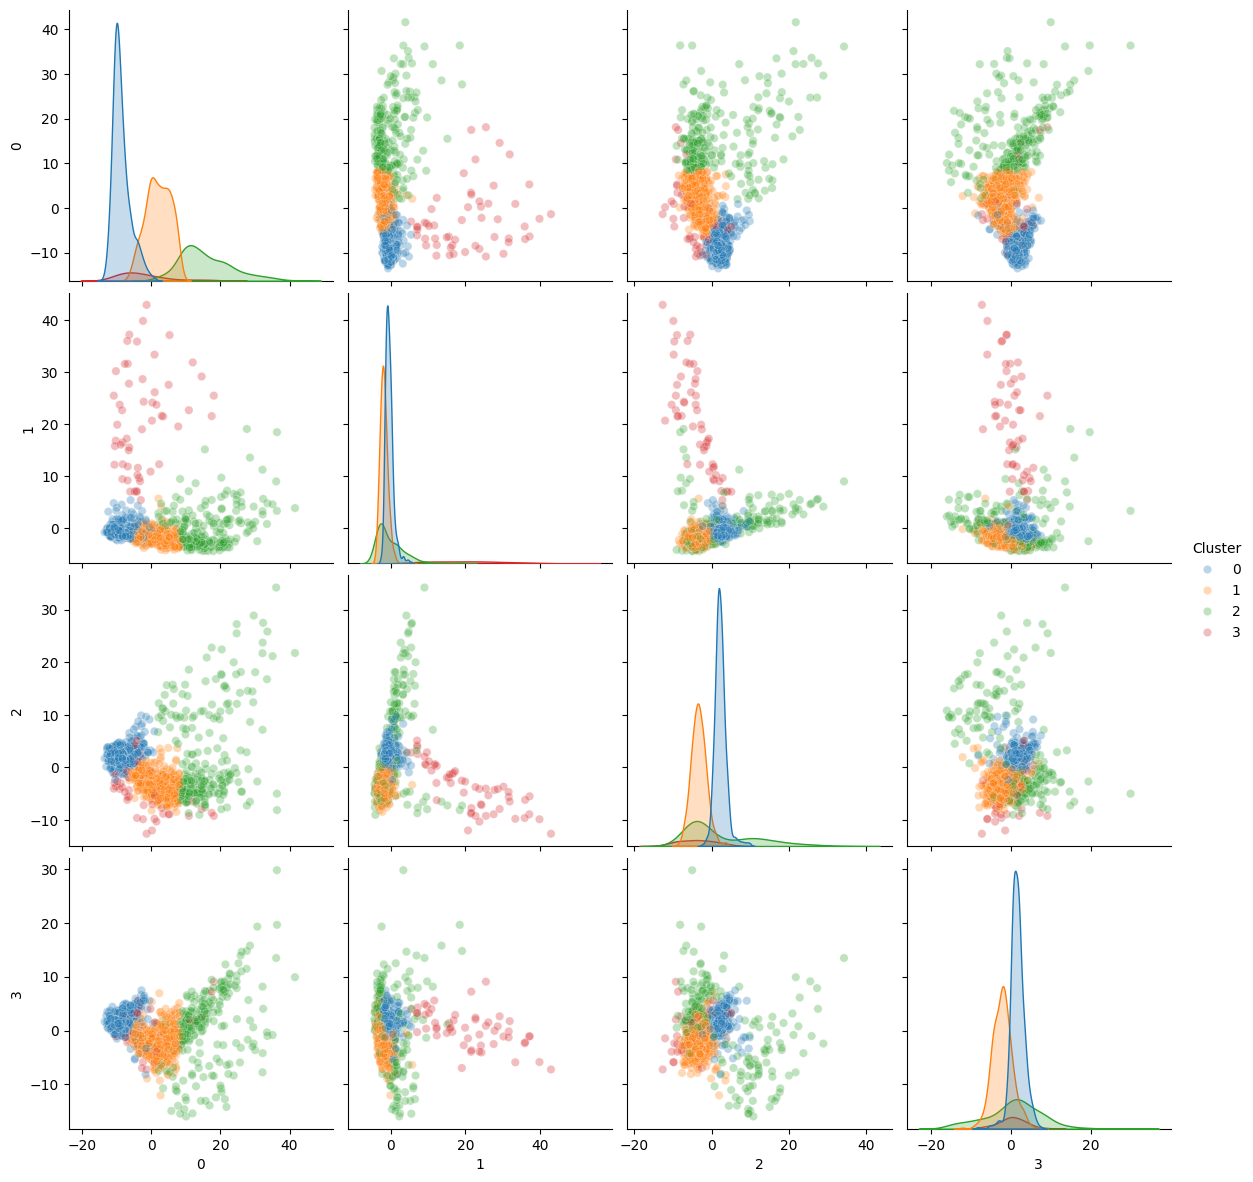

In [9]:
nmd_plot.plot_embedding_grid(data_all_pca.obsm["X_pca"][:,:4], hue=data_all_pca.obs["leiden_opt"], size=3)

## Fit NMD

In [10]:
k_opt = 4 # to match pca
beta_opt = 0.7
data_layer = "counts"

In [11]:
m, n = data_counts.X.shape
X_nmd = ut.convert_to_dense_counts(data_counts, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt)
Theta0 = W0 @ H0

In [12]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt, W0=W0, H0=H0, beta1=beta_opt, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 62.005142] - 0.569368 secs
[1 : 61.614866] - 0.567119 secs
[2 : 61.243567] - 0.580082 secs
[3 : 61.023276] - 0.560974 secs
[4 : 60.940303] - 0.579563 secs
[5 : 60.852477] - 0.625977 secs
[6 : 60.852661] - 0.569720 secs
[7 : 60.810972] - 0.542631 secs
[8 : 60.778452] - 0.538425 secs
[9 : 60.793873] - 0.563672 secs
[10 : 60.772023] - 0.548795 secs
[11 : 60.754786] - 0.550868 secs
[12 : 60.771211] - 0.561901 secs
[13 : 60.758889] - 0.561808 secs
[14 : 60.745616] - 0.552983 secs
[15 : 60.761743] - 0.548188 secs
[16 : 60.750322] - 0.550952 secs
[17 : 60.739098] - 0.537267 secs
[18 : 60.754311] - 0.530141 secs
[19 : 60.744619] - 0.747616 secs
[20 : 60.733281] - 0.697723 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 60.74754560807414%, after 22 iterations.
Initialization time: 0.401554 secs
Mean time per iteration: 0.570437 secs
Total time: 12.951170 secs



In [13]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

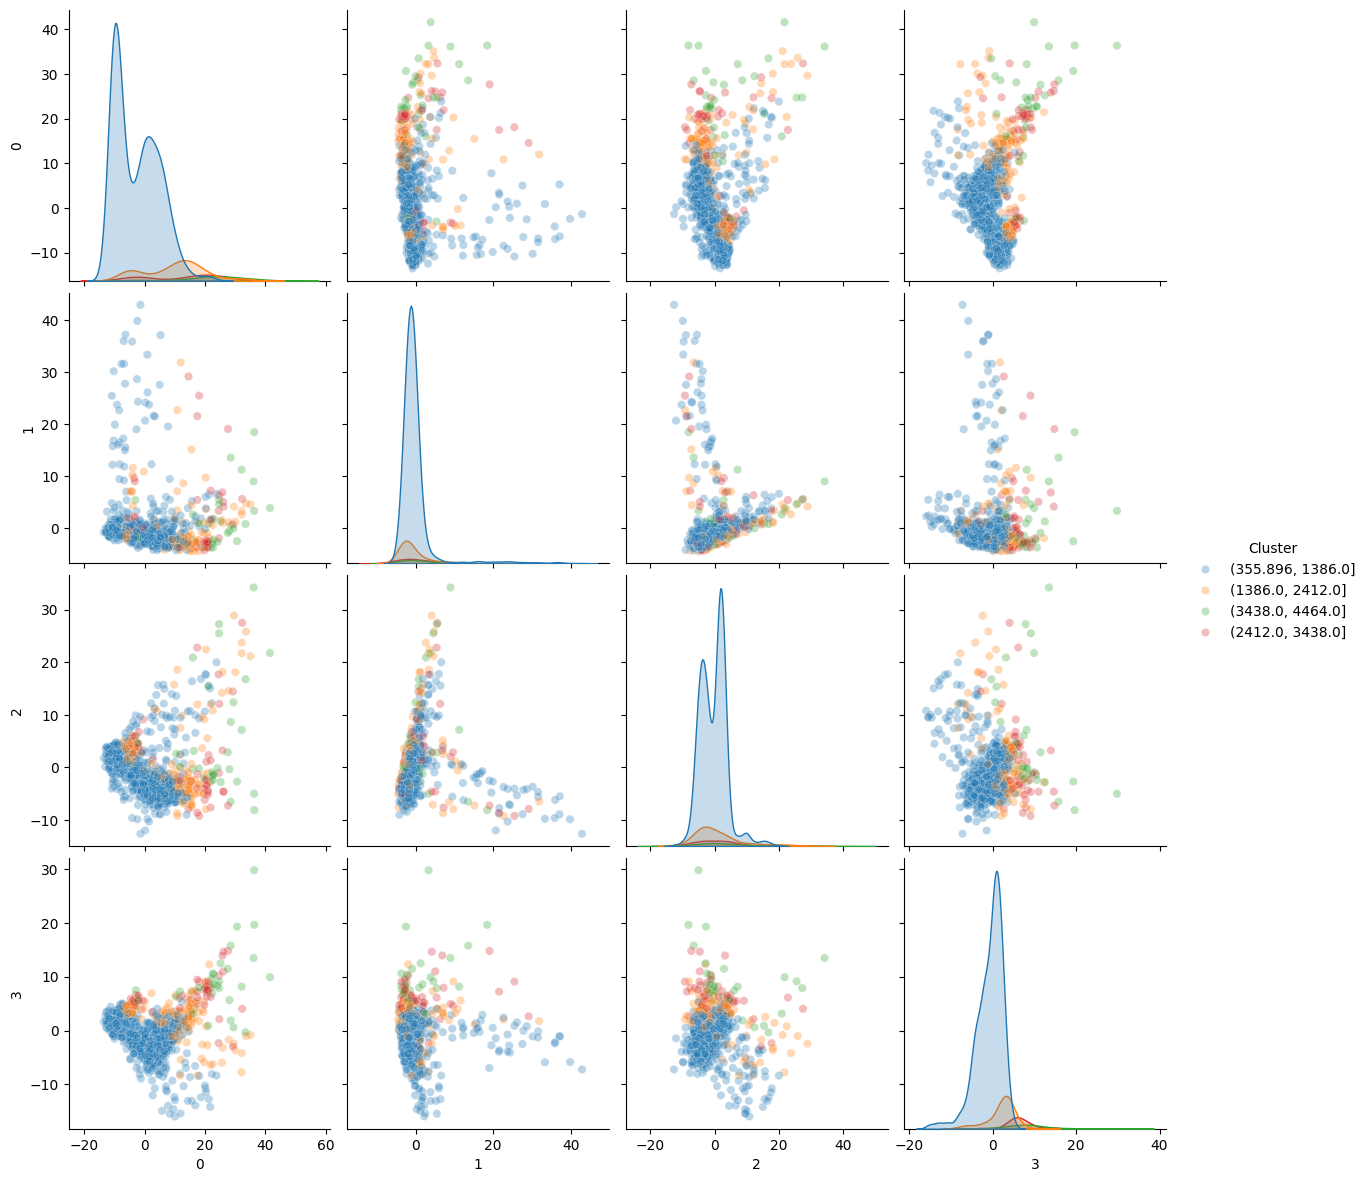

In [14]:
nmd_plot.plot_embedding_grid(data_all_pca.obsm["X_pca"][:,:4], hue=pd.cut(data_counts.obs["total_counts"], bins=4), size=3)

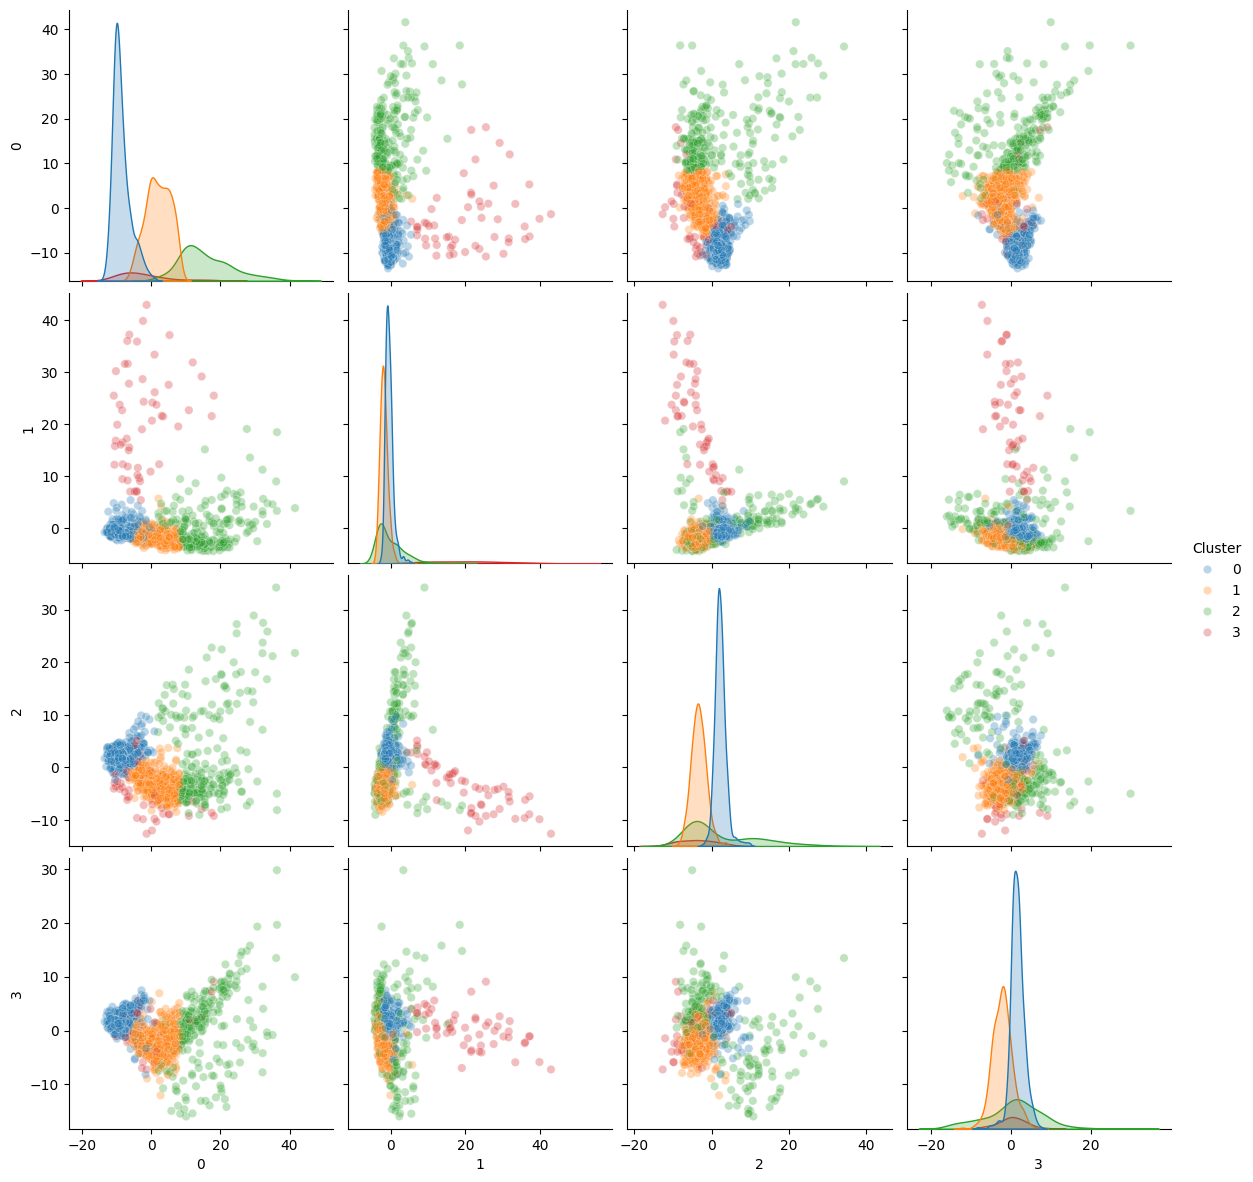

In [15]:
nmd_plot.plot_embedding_grid(data_all_pca.obsm["X_pca"][:,:4], hue=data_all_pca.obs["leiden_opt"], size=3)

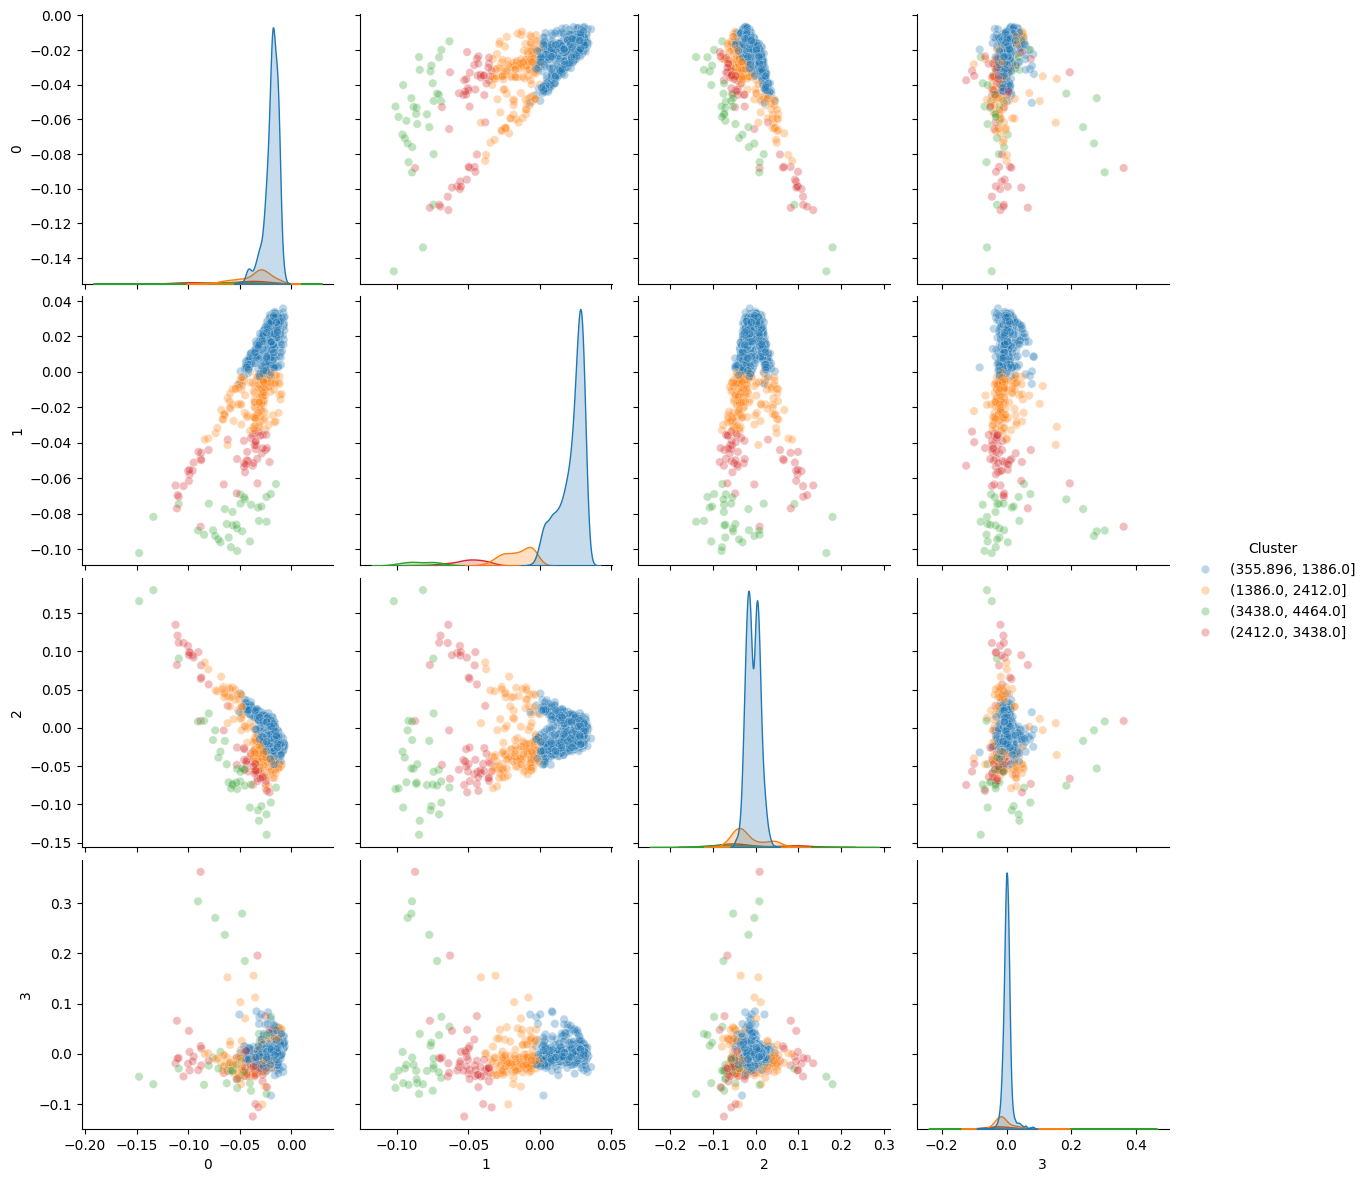

In [16]:
nmd_plot.plot_embedding_grid(W0, hue=pd.cut(data_counts.obs["total_counts"], bins=4), size=3)

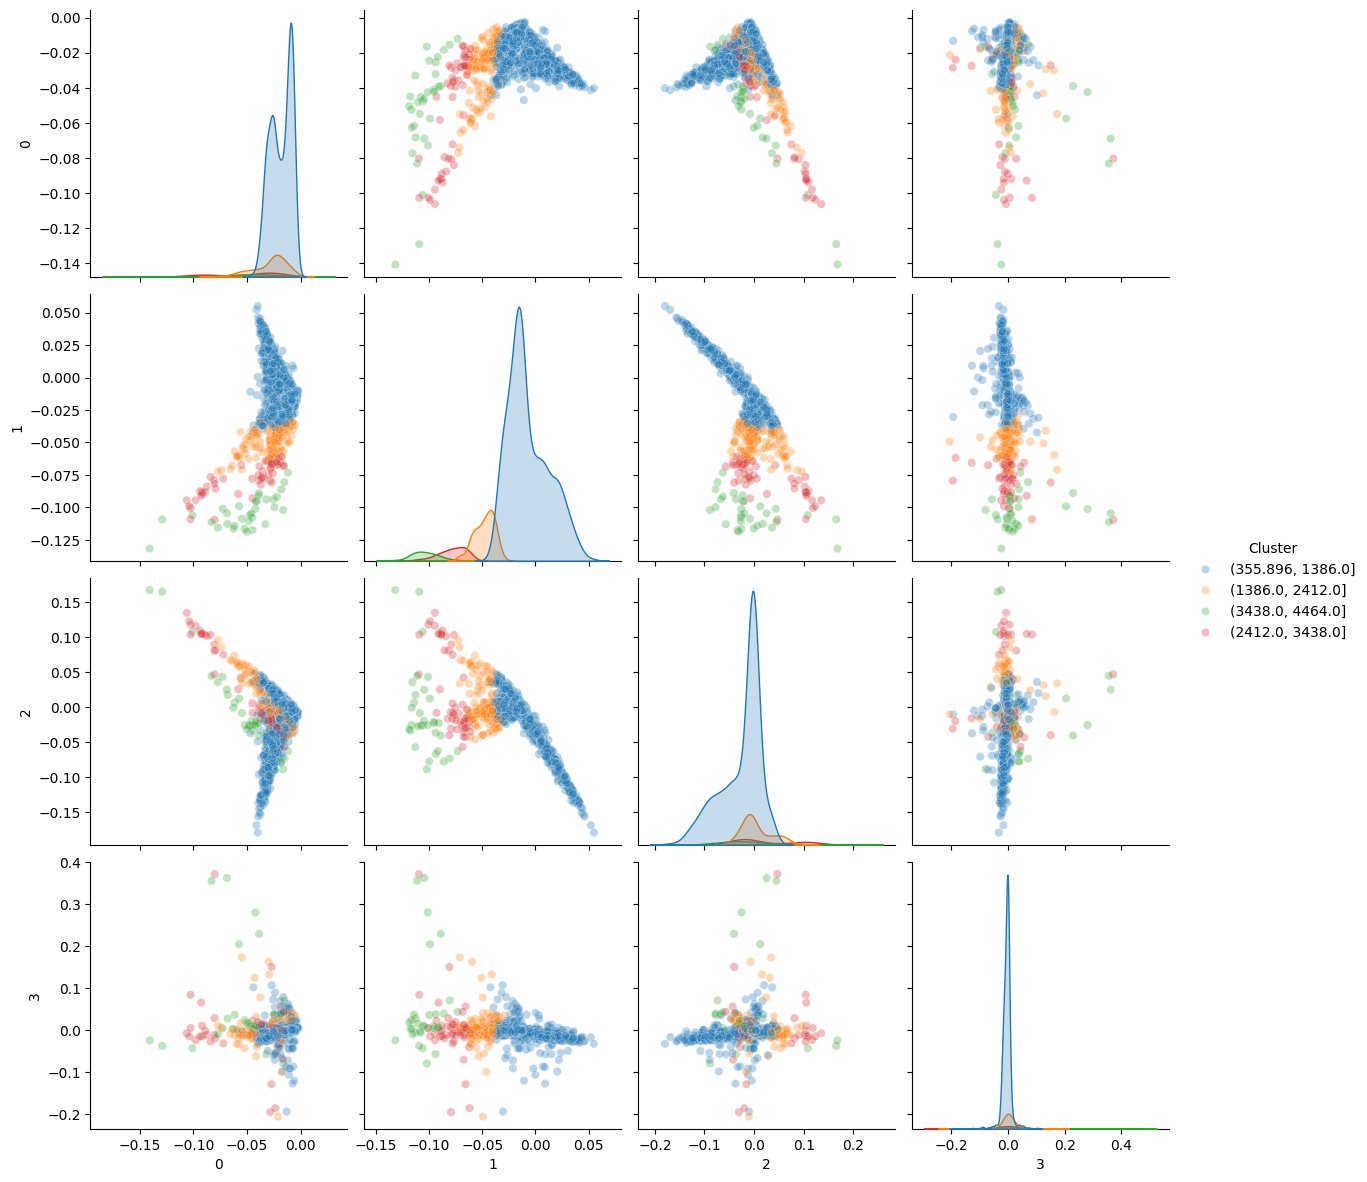

In [17]:
nmd_plot.plot_embedding_grid(W_3b, hue=pd.cut(data_counts.obs["total_counts"], bins=4), size=3)

In [18]:
df_pca = pd.DataFrame(data_all_pca.obsm["X_pca"][:,:4].copy())
df_nmd = pd.DataFrame(W_3b)

In [19]:
df_pca.columns = ["pca_dim1", "pca_dim2", "pca_dim3", "pca_dim4"]
df_nmd.columns = [f"nmd_dim{i + 1}" for i in df_nmd.columns.values]

In [20]:
df_both = pd.concat([df_pca, df_nmd], axis=1)
df_both["total_counts"] = data_counts.obs["total_counts"].tolist()
df_both["total_counts_grouped"] = pd.cut(df_both["total_counts"], bins=4)
df_both["pca_cluster"] = data_all_pca.obs["leiden_opt"].tolist()

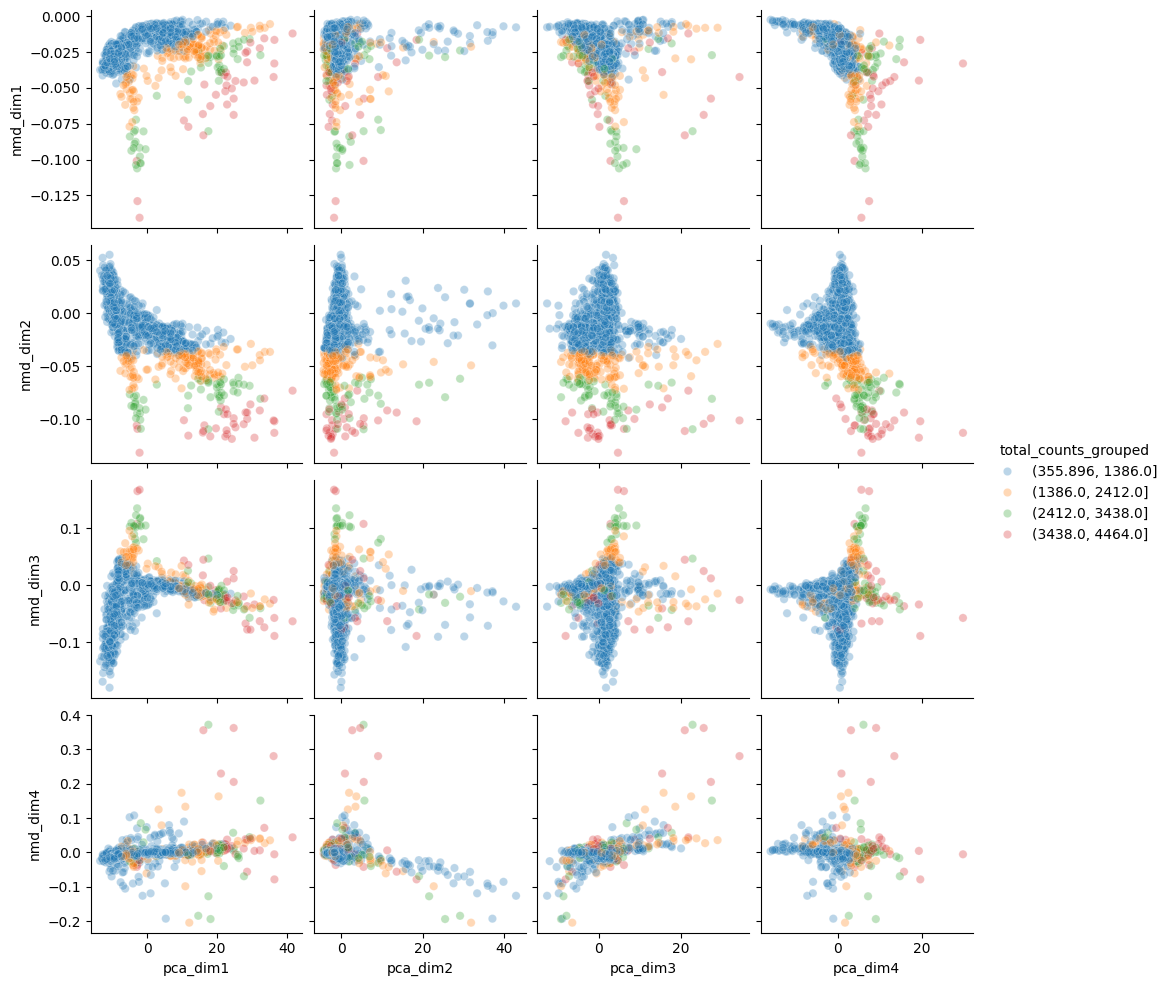

In [21]:
sns.pairplot(df_both, x_vars=df_pca.columns, y_vars=df_nmd.columns.values, hue="total_counts_grouped", plot_kws={"alpha": 0.3})

<Axes: >

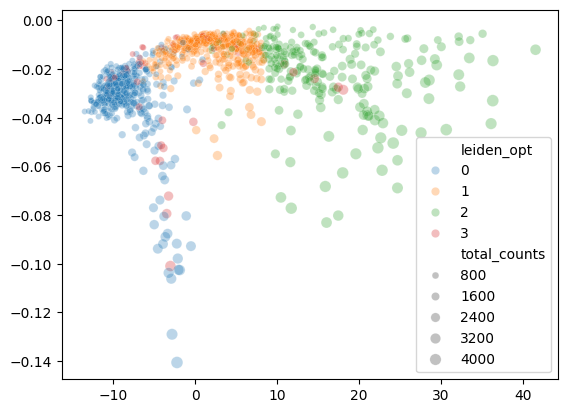

In [22]:
sns.scatterplot(x = data_all_pca.obsm["X_pca"][:,0], y=W_3b[:,0], size=data_counts.obs["total_counts"], alpha=0.3, hue=data_all_pca.obs["leiden_opt"])

<Axes: >

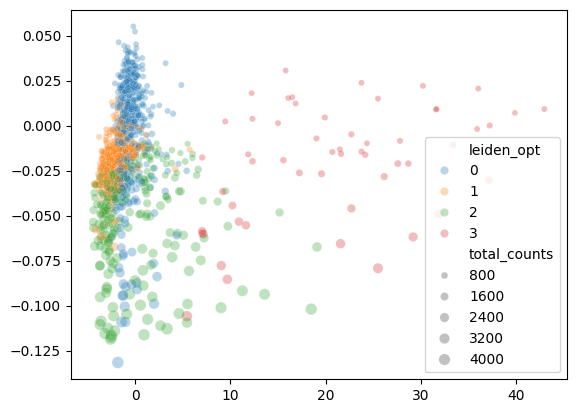

In [23]:
sns.scatterplot(x = data_all_pca.obsm["X_pca"][:,1], y=W_3b[:,1], 
                size=data_counts.obs["total_counts"], 
                alpha=0.3, hue=data_all_pca.obs["leiden_opt"])

<Axes: >

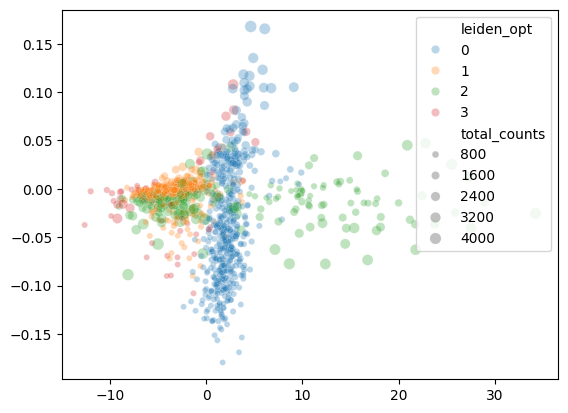

In [24]:
sns.scatterplot(x = data_all_pca.obsm["X_pca"][:,2], y=W_3b[:,2], 
                size=data_counts.obs["total_counts"], 
                alpha=0.3, hue=data_all_pca.obs["leiden_opt"])

<Axes: >

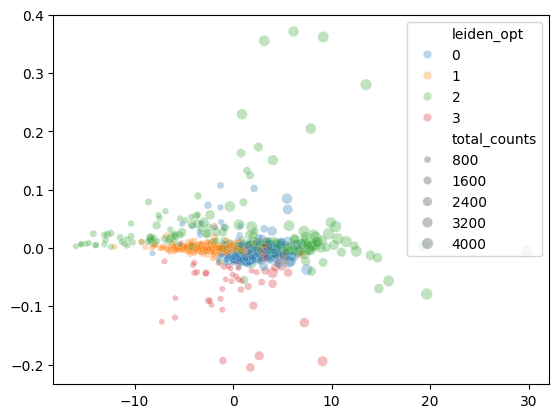

In [25]:
sns.scatterplot(x = data_all_pca.obsm["X_pca"][:,3], y=W_3b[:,3], 
                size=data_counts.obs["total_counts"], 
                alpha=0.3, hue=data_all_pca.obs["leiden_opt"])

In [26]:
data_counts

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'

Cluster 3: vermutlich selbes expression profile aber geringere Sequencingdepth

<Axes: >

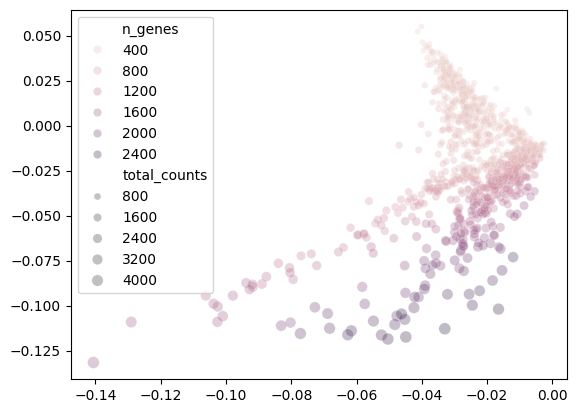

In [27]:
sns.scatterplot(x = W_3b[:,0], y=W_3b[:,1], 
                size=data_counts.obs["total_counts"], 
                alpha=0.3, hue=data_counts.obs["n_genes"])

In [30]:
data_train, data_test = cs.countsplit_adata(data_counts, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)

In [31]:
data_counts.obsm["X_3b"] = W_3b.copy()

In [32]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(
    data_counts, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, layer = "counts",
    embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed_nmd")

calculating (10, 0.05) - run 1/85


2024-03-15 09:51:32.358692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 09:51:32.358791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 09:51:32.362281: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 09:51:32.378370: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 30
Optimal min_dist: 0.5


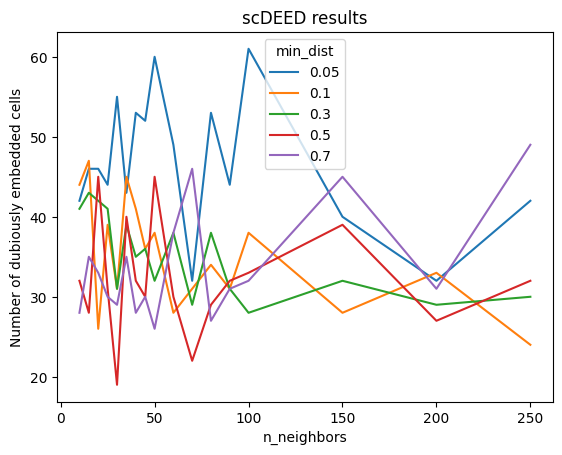

In [33]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [34]:
sc.pp.neighbors(data_counts, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_counts, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

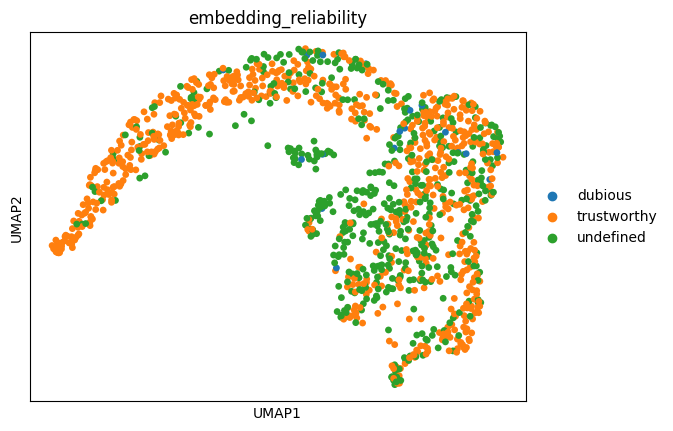

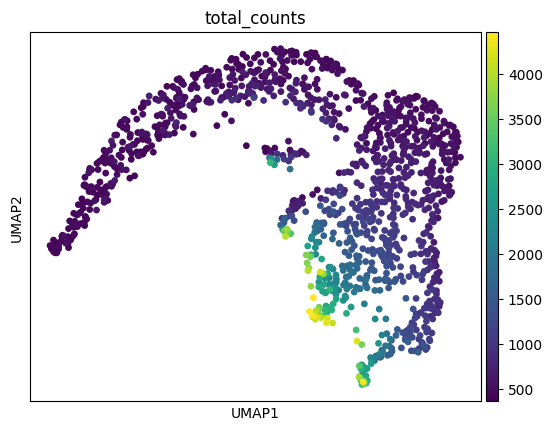

In [35]:
sc.pl.umap(data_counts, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_counts, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [36]:
X_train = ut.convert_to_dense_counts(data_train, layer=data_layer)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, k_opt)

In [37]:
X_test = ut.convert_to_dense_counts(data_test, layer=data_layer)
m, n = X_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, k_opt)

In [38]:
_, W_train, H_train,  _, _, _ = nmd.nmd_3b(X_train, r=k_opt, W0=W0_train, H0=H0_train, beta1=.8)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 76.021857] - 0.633173 secs
[1 : 75.792946] - 0.633592 secs
[2 : 75.923671] - 0.644217 secs
[3 : 76.046531] - 0.644762 secs
[4 : 75.901036] - 0.632280 secs
[5 : 75.760502] - 0.646513 secs
[6 : 75.650453] - 0.651625 secs
[7 : 75.569300] - 0.641396 secs
[8 : 75.481503] - 0.635440 secs
[9 : 75.520173] - 0.636666 secs
[10 : 75.455824] - 0.644494 secs
[11 : 75.413891] - 0.648484 secs
[12 : 75.453675] - 0.638475 secs
[13 : 75.418990] - 0.652043 secs
[14 : 75.378157] - 0.658463 secs
[15 : 75.416633] - 0.669143 secs
[16 : 75.382910] - 0.657939 secs
[17 : 75.370229] - 0.661134 secs
[18 : 75.390517] - 0.677057 secs
[19 : 75.355754] - 0.679227 secs
[20 : 75.336265] - 0.662628 secs
[21 : 75.370174] - 0.670864 secs
[22 : 75.330146] - 0.678005 secs
[23 : 75.309417] - 0.677512 secs
[24 : 75.332222] - 0.669787 secs
[25 : 75.301166] - 0.671687 secs
[26 : 75.264244] - 0.672969 secs
[27 : 75.290457] - 0.670232 

In [39]:
_, W_test, H_test,  _, _, _ = nmd.nmd_3b(X_test, r=k_opt, W0=W0_test, H0=H0_test, beta1=.8)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 74.730206] - 0.574430 secs
[1 : 74.506741] - 0.561619 secs
[2 : 74.663181] - 0.585813 secs
[3 : 74.845735] - 0.572361 secs
[4 : 74.754002] - 0.572646 secs
[5 : 74.689739] - 0.555755 secs
[6 : 74.558747] - 0.570774 secs
[7 : 74.463835] - 0.574473 secs
[8 : 74.347590] - 0.571394 secs
[9 : 74.343665] - 0.550779 secs
[10 : 74.279270] - 0.558165 secs
[11 : 74.220276] - 0.559996 secs
[12 : 74.231541] - 0.553319 secs
[13 : 74.201229] - 0.554619 secs
[14 : 74.169938] - 0.566905 secs
[15 : 74.189680] - 0.566580 secs
[16 : 74.164683] - 0.582865 secs
[17 : 74.151235] - 0.576796 secs
[18 : 74.167357] - 0.563949 secs
[19 : 74.146375] - 0.564935 secs
[20 : 74.128649] - 0.552046 secs
[21 : 74.154027] - 0.540297 secs
[22 : 74.123806] - 0.553801 secs
[23 : 74.104837] - 0.554032 secs
[24 : 74.124062] - 0.554101 secs
[25 : 74.099788] - 0.541649 secs
[26 : 74.075759] - 0.549537 secs
[27 : 74.092208] - 0.552139 

In [40]:
data_train.obsm["X_3b"] = W_train
data_test.obsm["X_3b"] = W_test

In [41]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

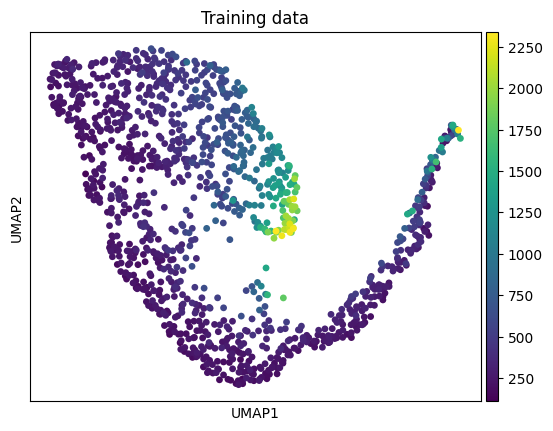

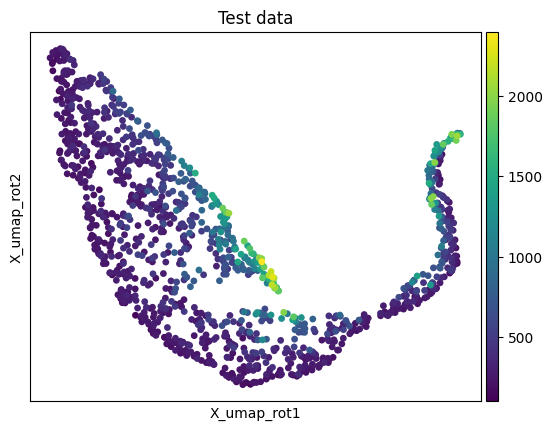

In [42]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

In [44]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

In [45]:
sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

In [46]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.477 - Test: 0.262 - Random: 0.237
resolution: 0.05 - clusters: 2 - Train: 0.467 - Test: 0.252 - Random: 0.228
resolution: 0.07 - clusters: 3 - Train: 0.458 - Test: 0.198 - Random: 0.165
resolution: 0.09 - clusters: 3 - Train: 0.451 - Test: 0.19 - Random: 0.157
resolution: 0.11 - clusters: 5 - Train: 0.445 - Test: 0.153 - Random: 0.085
resolution: 0.13 - clusters: 5 - Train: 0.44 - Test: 0.149 - Random: 0.082
resolution: 0.15 - clusters: 5 - Train: 0.436 - Test: 0.144 - Random: 0.076
resolution: 0.17 - clusters: 5 - Train: 0.431 - Test: 0.14 - Random: 0.073
resolution: 0.19 - clusters: 6 - Train: 0.426 - Test: 0.111 - Random: 0.058
resolution: 0.21 - clusters: 6 - Train: 0.422 - Test: 0.107 - Random: 0.054
resolution: 0.23 - clusters: 5 - Train: 0.42 - Test: 0.12 - Random: 0.054
resolution: 0.25 - clusters: 6 - Train: 0.416 - Test: 0.113 - Random: 0.048
resolution: 0.27 - c

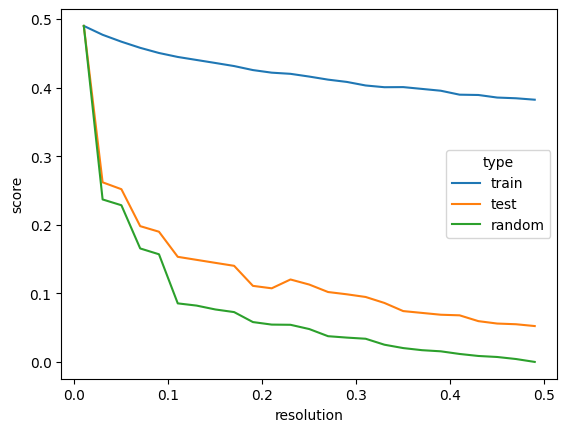

In [47]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

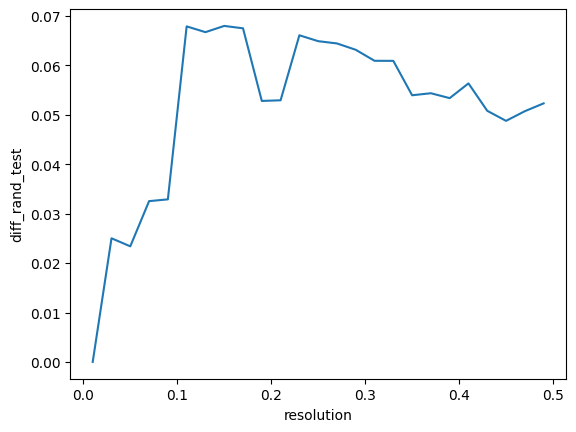

In [49]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [50]:
sc.tl.leiden(data_counts, resolution=res_opt, key_added="leiden_opt")

In [51]:
data_counts

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    uns: 'pca', 'neighbors', 'umap', 'embedding_reliability_colors', 'leiden'
    obsm: 'X_pca', 'X_3b', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

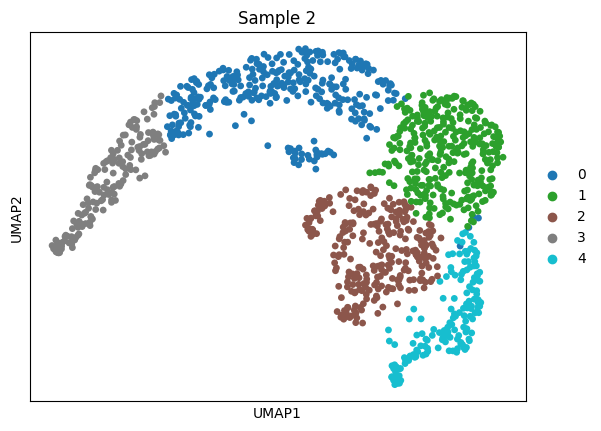

In [52]:
sc.pl.umap(data_counts, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

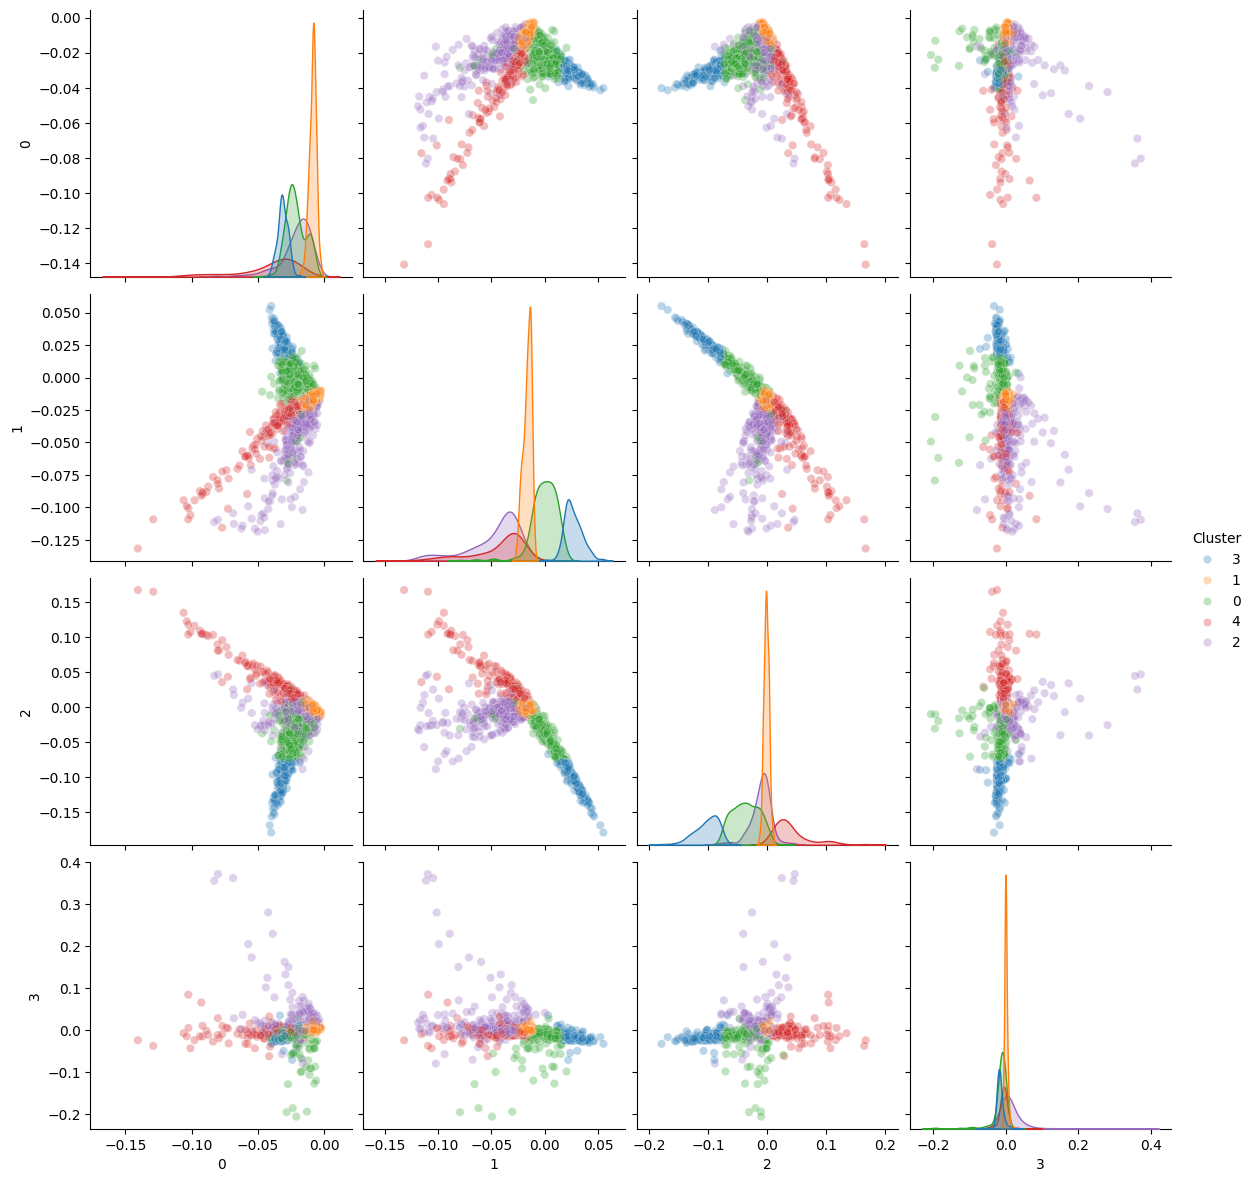

In [53]:
nmd_plot.plot_embedding_grid(data_counts.obsm["X_3b"], hue=data_counts.obs["leiden_opt"], size=3)


In [54]:
pd.crosstab(data_all_pca.obs["leiden_opt"], data_counts.obs["leiden_opt"], rownames=['PCA'], colnames=['NMD'])

NMD    0    1    2    3    4
PCA                         
0    223    7   12  156  118
1     69  292   61    2   23
2      1   25  208    0    4
3     38    1    0    4   11

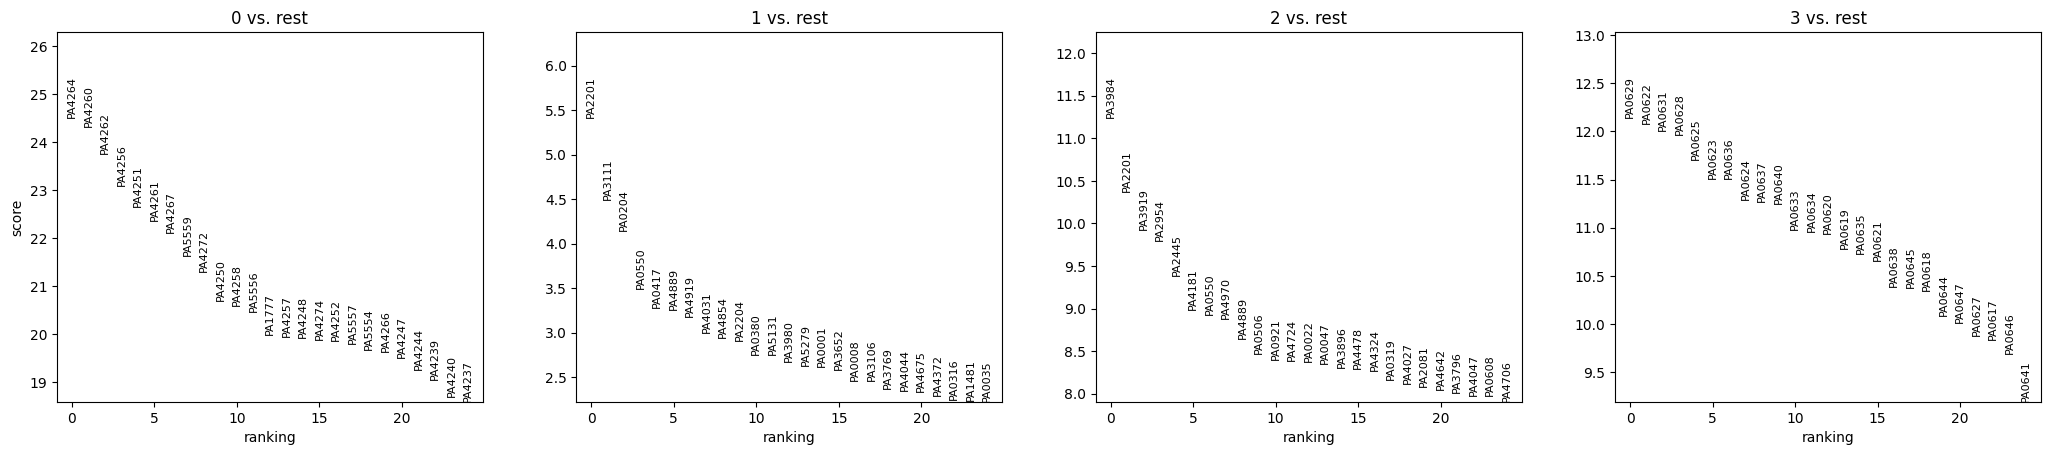

In [57]:
sc.tl.rank_genes_groups(data_all_pca, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_all_pca, n_genes=25, sharey=False)

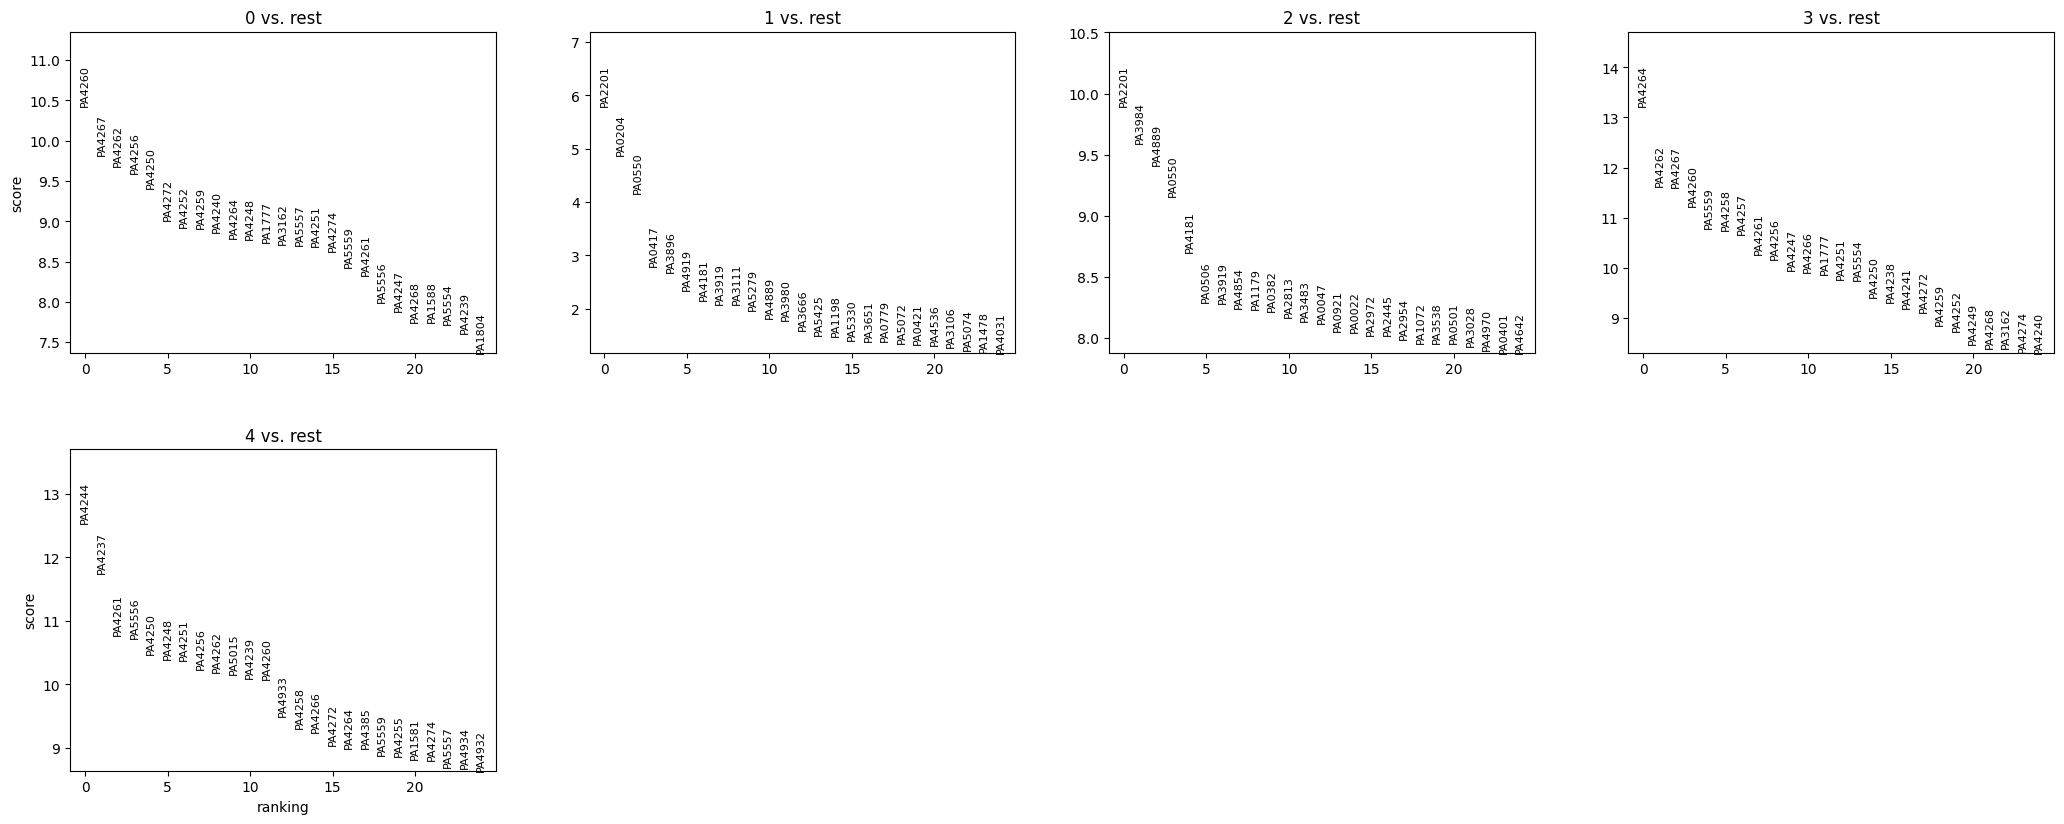

In [58]:
sc.tl.rank_genes_groups(data_counts, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_counts, n_genes=25, sharey=False)

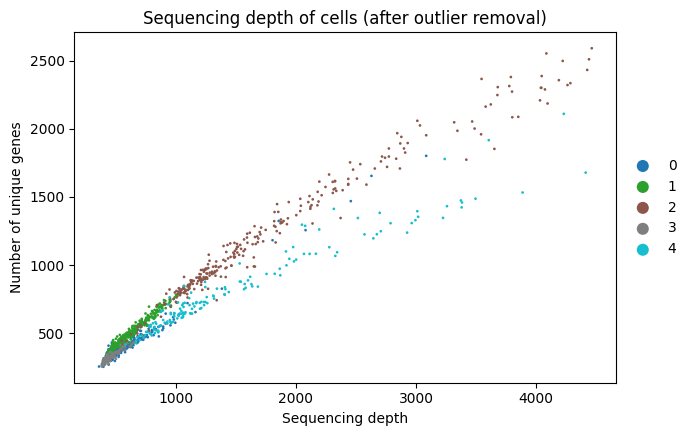

In [59]:
sc.pl.scatter(data_counts, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [60]:
top_genes_3 = [x[3] for x in data_counts.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA4264', 'PA4262', 'PA4267', 'PA4260', 'PA5559', 'PA4258', 'PA4257', 'PA4261', 'PA4256', 'PA4247', 'PA4266', 'PA1777', 'PA4251', 'PA5554', 'PA4250', 'PA4238', 'PA4241', 'PA4272', 'PA4259', 'PA4252', 'PA4249', 'PA4268', 'PA3162', 'PA4274', 'PA4240']


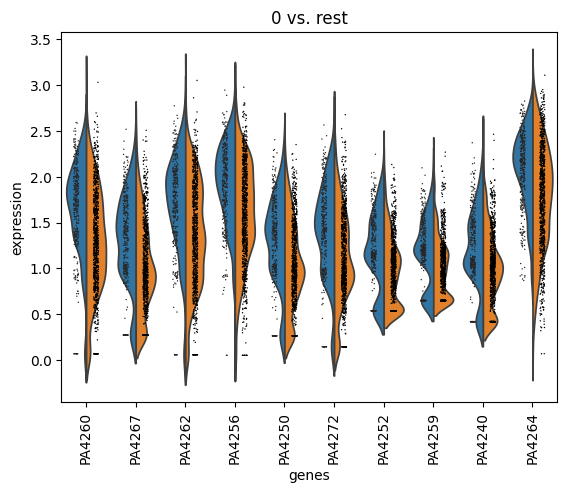

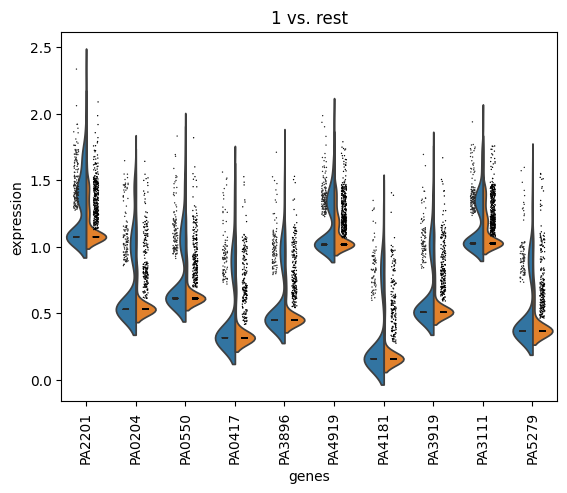

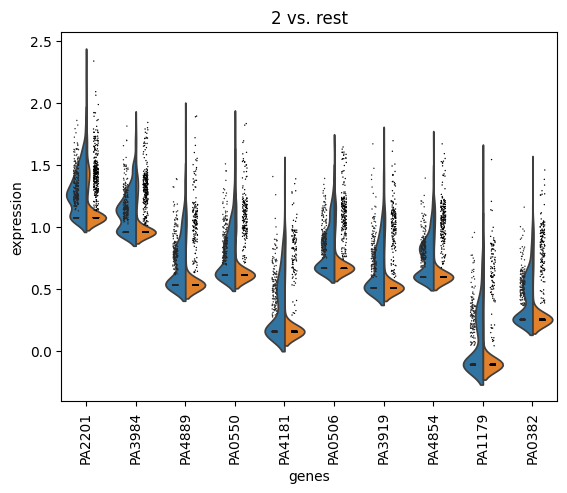

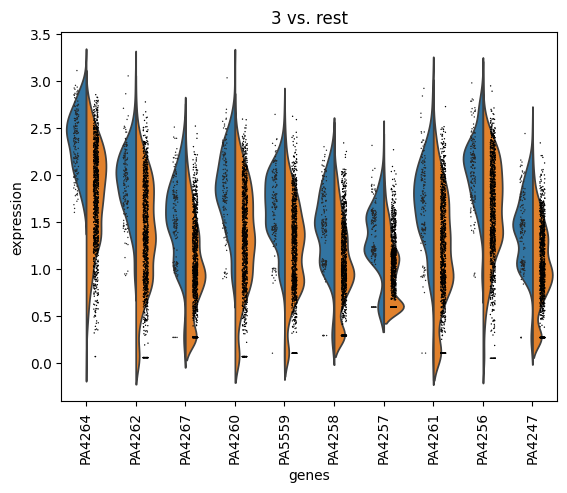

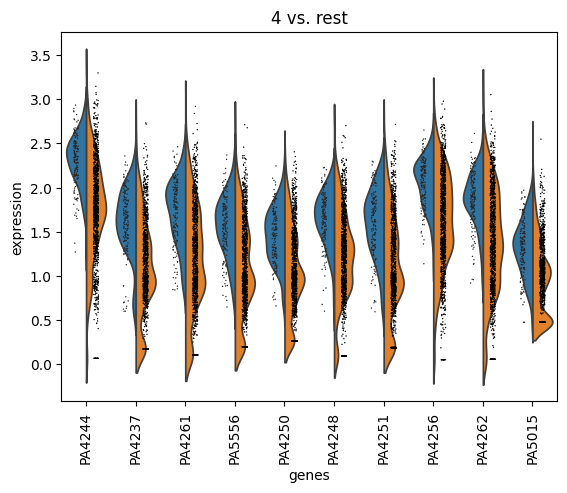

In [61]:
nclust = len(np.unique(data_counts.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_counts, groups=str(i), n_genes=10)